In [1]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf  # ดึงข้อมูลหุ้น
import pandas as pd  # จัดการข้อมูลตาราง
import numpy as np  # คำนวณตัวเลข
from sklearn.preprocessing import StandardScaler  # ปรับสเกลข้อมูล
from sklearn.svm import SVC  # โมเดล Support Vector Machine
from sklearn.model_selection import train_test_split  # แบ่งข้อมูลเทรนกับเทสต์
from sklearn.metrics import accuracy_score  # ประเมินความแม่นยำโมเดล

import yfinance as yf
df = yf.download("advanc.bk", start="2020-01-01", end="2025-06-13")
df=df[['Open', 'High','Low','Close']]

# ถ้า Date เป็น index เดิม ต้อง reset ออกมาก่อน
if df.index.name == 'Date':
    df = df.reset_index()

# เปลี่ยนชื่อคอลัมน์ให้ตรงตามลำดับ
df.columns = ['Date', 'Open', 'High', 'Low', 'Close']

# 2. สร้าง Label ง่าย ๆ เช่น ถ้าปิดวันถัดไปสูงกว่าปิดวันนี้ ให้เป็น 1 (ราคาขึ้น)
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# แปลง Date เป็น datetime และตั้งเป็น index ใหม่
df['Date'] = pd.to_datetime(df['Date'])



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
print(df)

           Date        Open        High         Low       Close  Target
0    2020-01-02  173.490075  177.543581  171.868672  176.732880       0
1    2020-01-03  175.111465  175.922167  174.300764  175.111465       1
2    2020-01-06  175.111464  178.354269  175.111464  175.922165       1
3    2020-01-07  176.732901  181.597109  175.922199  180.786407       0
4    2020-01-08  179.164965  180.786367  177.543562  178.354263       0
...         ...         ...         ...         ...         ...     ...
1313 2025-06-06  293.000000  295.000000  289.000000  290.000000       0
1314 2025-06-09  291.000000  292.000000  288.000000  289.000000       0
1315 2025-06-10  288.000000  291.000000  287.000000  288.000000       1
1316 2025-06-11  288.000000  293.000000  288.000000  292.000000       0
1317 2025-06-12  291.000000  291.000000  285.000000  286.000000       0

[1318 rows x 6 columns]


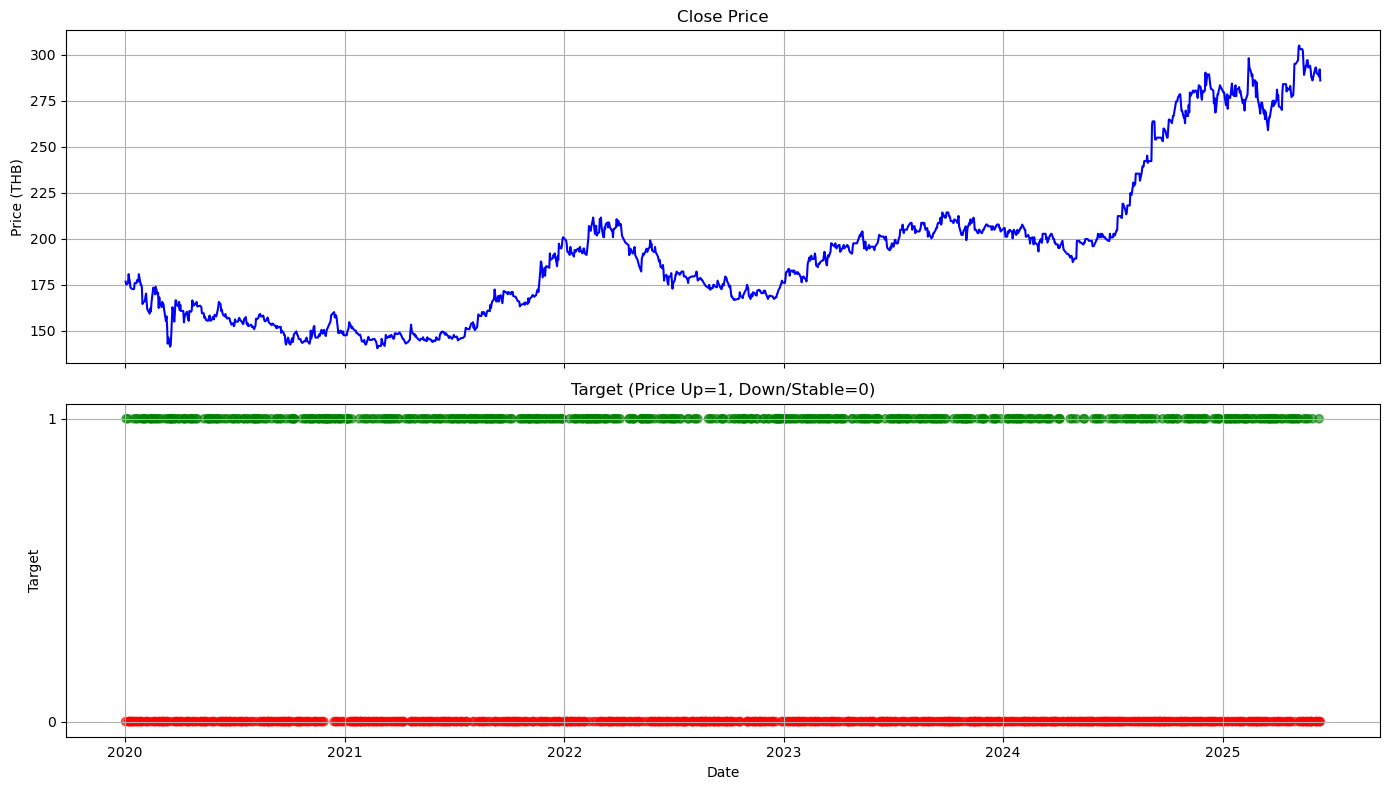

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True)

# กราฟราคาปิด
ax1.plot(df['Date'], df['Close'], color='blue')
ax1.set_title('Close Price')
ax1.set_ylabel('Price (THB)')
ax1.grid(True)

# กราฟ Target
ax2.scatter(df['Date'], df['Target'], c=df['Target'].map({0:'red', 1:'green'}), marker='o', alpha=0.6)
ax2.set_title('Target (Price Up=1, Down/Stable=0)')
ax2.set_ylabel('Target')
ax2.set_yticks([0, 1])
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()



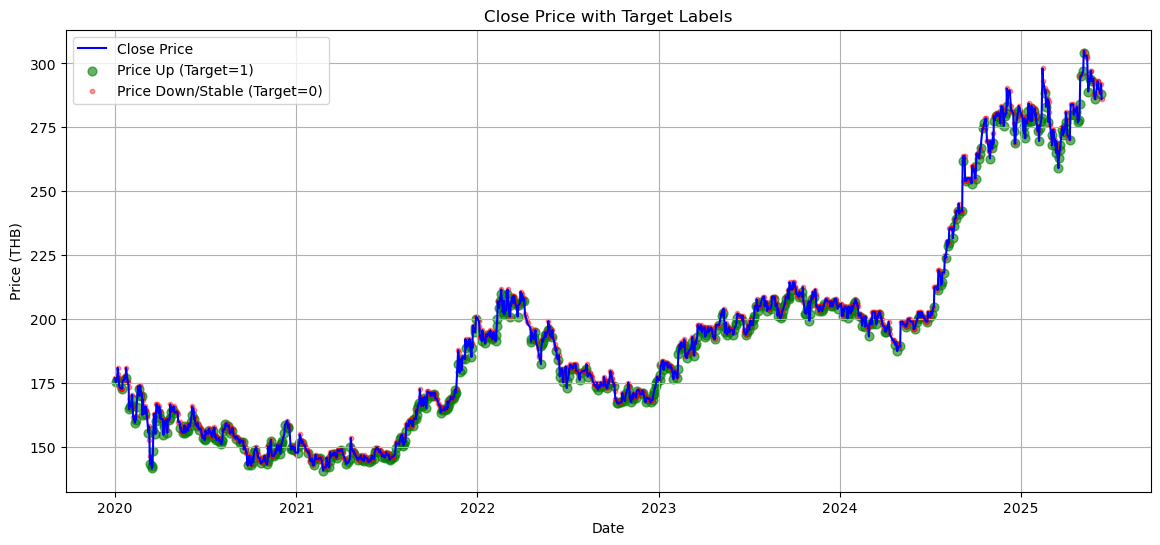

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# วาดเส้นราคาปิด
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')

# วาดจุด Target ที่เป็น 1 (ราคาขึ้น) ด้วยสีเขียว จุดใหญ่
plt.scatter(df.loc[df['Target'] == 1, 'Date'], 
            df.loc[df['Target'] == 1, 'Close'], 
            color='green', label='Price Up (Target=1)', s=40, alpha=0.6)

# วาดจุด Target ที่เป็น 0 (ราคาลงหรือเท่าเดิม) ด้วยสีแดง จุดเล็ก
plt.scatter(df.loc[df['Target'] == 0, 'Date'], 
            df.loc[df['Target'] == 0, 'Close'], 
            color='red', label='Price Down/Stable (Target=0)', s=10, alpha=0.4)

plt.title('Close Price with Target Labels')
plt.xlabel('Date')
plt.ylabel('Price (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# กรองข้อมูลเฉพาะวันที่ Target=1
buy_signals = df[df['Target'] == 1][['Date', 'Close']]

# แสดงข้อมูล
print(buy_signals.reset_index(drop=True))


          Date       Close
0   2020-01-03  175.111465
1   2020-01-06  175.922165
2   2020-01-16  172.679382
3   2020-01-20  175.922165
4   2020-01-23  176.732880
..         ...         ...
530 2025-05-16  289.000000
531 2025-05-20  294.000000
532 2025-05-23  293.000000
533 2025-05-30  286.000000
534 2025-06-10  288.000000

[535 rows x 2 columns]


In [6]:
# 1. หาสัญญาณ Target = 1 แรก
first_buy_signal = df[df['Target'] == 1].iloc[0]
buy_date = first_buy_signal['Date']
buy_price = first_buy_signal['Close']

print(f"🔹 สัญญาณซื้อแรกเกิดขึ้นวันที่: {buy_date.date()} ที่ราคาปิด: {buy_price:.2f}")

# 2. เลือกข้อมูลหลังจากวันซื้อ เพื่อดูว่าราคาลงไปแค่ไหน แล้วดีดกลับ
after_buy = df[df['Date'] > buy_date].copy()
after_buy.reset_index(drop=True, inplace=True)

# หาจุดต่ำสุดหลังจากซื้อ
min_price_idx = after_buy['Close'].idxmin()
min_price_row = after_buy.loc[min_price_idx]
min_date = min_price_row['Date']
min_price = min_price_row['Close']

print(f"🔻 ราคาต่ำสุดหลังสัญญาณซื้อ: {min_price:.2f} วันที่: {min_date.date()}")

# หาราคาสูงสุดหลังจุดต่ำสุด (ช่วง rebound แรก)
rebound = after_buy[after_buy['Date'] > min_date]
max_price_row = rebound.loc[rebound['Close'].idxmax()]
rebound_date = max_price_row['Date']
rebound_price = max_price_row['Close']

print(f"🔺 ราคาสูงสุดช่วง rebound: {rebound_price:.2f} วันที่: {rebound_date.date()}")



🔹 สัญญาณซื้อแรกเกิดขึ้นวันที่: 2020-01-03 ที่ราคาปิด: 175.11
🔻 ราคาต่ำสุดหลังสัญญาณซื้อ: 140.52 วันที่: 2021-02-24
🔺 ราคาสูงสุดช่วง rebound: 305.00 วันที่: 2025-05-08


C:\Users\User\AppData\Local\Temp\ipykernel_25912\1581551576.py:27: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25912\1581551576.py:27: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_25912\1581551576.py:27: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\py

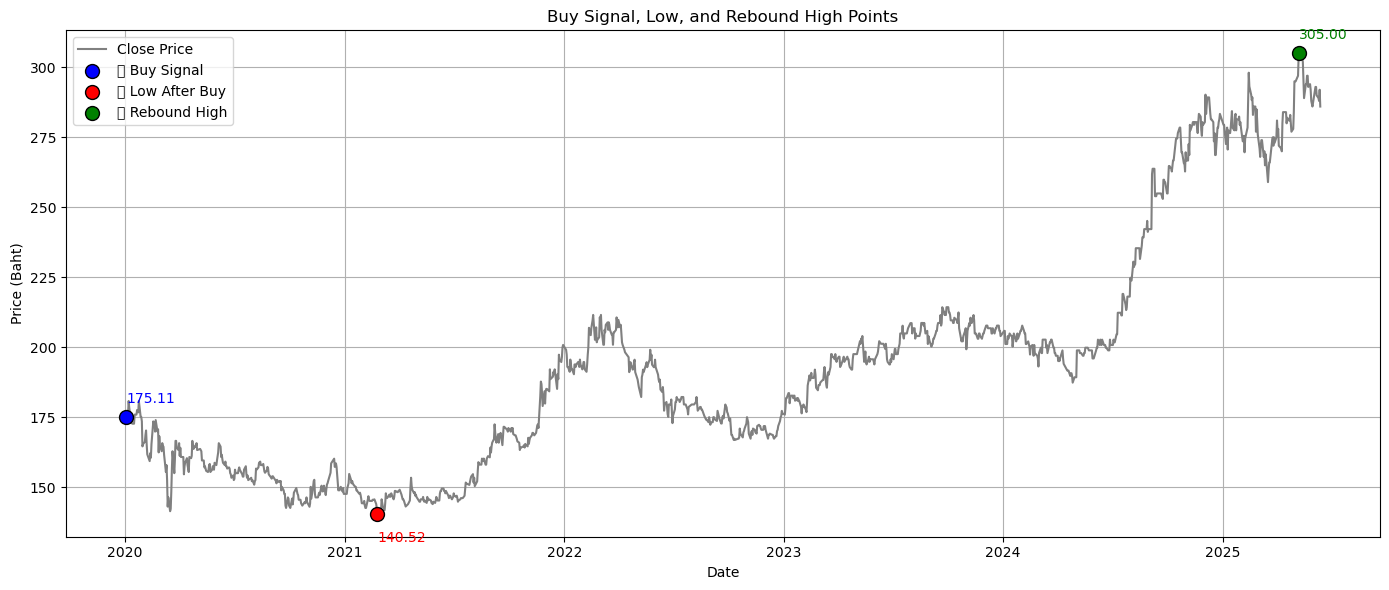

In [7]:
import matplotlib.pyplot as plt

# วาดกราฟราคาปิด
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='gray')

# วงกลมจุดสัญญาณซื้อ
plt.scatter(buy_date, buy_price, color='blue', label='🔹 Buy Signal', s=100, edgecolors='black', zorder=5)

# วงกลมจุดต่ำสุด
plt.scatter(min_date, min_price, color='red', label='🔻 Low After Buy', s=100, edgecolors='black', zorder=5)

# วงกลมจุด rebound
plt.scatter(rebound_date, rebound_price, color='green', label='🔺 Rebound High', s=100, edgecolors='black', zorder=5)

# เพิ่มข้อความประกอบ
plt.text(buy_date, buy_price + 5, f'{buy_price:.2f}', color='blue')
plt.text(min_date, min_price - 10, f'{min_price:.2f}', color='red')
plt.text(rebound_date, rebound_price + 5, f'{rebound_price:.2f}', color='green')

# จัดรูปแบบกราฟ
plt.title("Buy Signal, Low, and Rebound High Points")
plt.xlabel("Date")
plt.ylabel("Price (Baht)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:

# 3. ลบข้อมูลแถวสุดท้ายที่ไม่มี Target (เนื่องจาก shift(-1))
df = df[:-1]

# 4. เตรียมข้อมูล X (features) และ y (target)
X = df[['Open', 'High', 'Low', 'Close']].values
y = df['Target'].values

# 5. แบ่งข้อมูลเป็นชุดเทรนและชุดทดสอบ (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. ปรับสเกลข้อมูล (StandardScaler ช่วยให้ข้อมูลมี mean=0 และ std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. สร้างโมเดล SVM และเทรน
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model.fit(X_train_scaled, y_train)

# 8. ทำนายผลและประเมินความแม่นยำ
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM model: {accuracy:.4f}")


Accuracy of SVM model: 0.5682


In [9]:
print(df.dtypes)

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Target             int32
dtype: object


In [10]:
if df.index.name == 'Date':
    df = df.reset_index()

In [11]:
print(df)

           Date        Open        High         Low       Close  Target
0    2020-01-02  173.490075  177.543581  171.868672  176.732880       0
1    2020-01-03  175.111465  175.922167  174.300764  175.111465       1
2    2020-01-06  175.111464  178.354269  175.111464  175.922165       1
3    2020-01-07  176.732901  181.597109  175.922199  180.786407       0
4    2020-01-08  179.164965  180.786367  177.543562  178.354263       0
...         ...         ...         ...         ...         ...     ...
1312 2025-06-05  295.000000  295.000000  291.000000  293.000000       0
1313 2025-06-06  293.000000  295.000000  289.000000  290.000000       0
1314 2025-06-09  291.000000  292.000000  288.000000  289.000000       0
1315 2025-06-10  288.000000  291.000000  287.000000  288.000000       1
1316 2025-06-11  288.000000  293.000000  288.000000  292.000000       0

[1317 rows x 6 columns]


In [12]:
print(X)

[[173.49007451 177.54358092 171.86867194 176.73287964]
 [175.11146545 175.92216668 174.30076423 175.11146545]
 [175.1114637  178.35426858 175.1114637  175.92216492]
 ...
 [291.         292.         288.         289.        ]
 [288.         291.         287.         288.        ]
 [288.         293.         288.         292.        ]]


In [13]:
print(y)

[0 1 1 ... 0 1 0]


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import talib as ta  # ต้องติดตั้ง TA-Lib ให้เรียบร้อยก่อน


In [15]:

# 2. คำนวณ Indicator
df['EMA25'] = ta.EMA(df['Close'], timeperiod=25)
df['EMA75'] = ta.EMA(df['Close'], timeperiod=75)
df['EMA200'] = ta.EMA(df['Close'], timeperiod=200)
df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

macd, macdsignal, macdhist = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD_signal'] = macdsignal
df['MACD_hist'] = macdhist

# 3. ลบแถวที่มีค่า NaN (จากการคำนวณ indicator ช่วงแรก)
df.dropna(inplace=True)

# 4. สร้าง Target Signal ตัวอย่าง
# เงื่อนไขง่าย: EMA25 > EMA75 > EMA200 และ RSI < 70 => target = 1 (เทรนด์ขาขึ้น)
# ไม่งั้น target = 0
df['Target'] = np.where(
    (df['EMA25'] > df['EMA75']) &
    (df['EMA75'] > df['EMA200']) &
    (df['RSI'] < 70),
    1, 0
)

# 5. เตรียม Features และ Target
features = ['Open', 'High', 'Low', 'Close', 'EMA25', 'EMA75', 'EMA200', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist']
X = df[features].values
y = df['Target'].values

# 6. แบ่งข้อมูล train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7. ปรับสเกล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. สร้างโมเดล SVM และเทรน
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model.fit(X_train_scaled, y_train)

# 9. ทำนายและประเมินผล
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with EMA, RSI, MACD indicators: {accuracy:.4f}")

Accuracy with EMA, RSI, MACD indicators: 0.8750


In [16]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Target', 'EMA25', 'EMA75',
       'EMA200', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist'],
      dtype='object')


In [17]:
# กำหนดตัวแปรเป้าหมาย (Target)
y = df['Target']

# กำหนดตัวแปรต้น (Predictors) โดยไม่รวม Date และ Target
X = df[['Open', 'High', 'Low', 'Close', 
        'EMA25', 'EMA75', 'EMA200', 
        'RSI', 'MACD', 'MACD_signal', 'MACD_hist']]


In [18]:
from sklearn.model_selection import train_test_split

# ตัวแปรต้น (Features) และ ตัวแปรเป้าหมาย (Target)
X = df[['Open', 'High', 'Low', 'Close', 
        'EMA25', 'EMA75', 'EMA200', 
        'RSI', 'MACD', 'MACD_signal', 'MACD_hist']]
y = df['Target']

# แบ่งข้อมูลเป็น 80% train และ 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [19]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165
1314,2025-06-09,291.000000,292.000000,288.000000,289.000000,1,290.687313,284.557831,269.123834,47.914500,0.610458,1.736357,-1.125899
1315,2025-06-10,288.000000,291.000000,287.000000,288.000000,1,290.480597,284.648415,269.311656,46.561414,0.312027,1.451491,-1.139464


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# สร้าง Decision Tree Model
clf = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

# ฝึกโมเดลด้วย train set
clf.fit(X_train, y_train)

# ทำนายผลจาก test set
y_pred = clf.predict(X_test)

# ประเมินผลโมเดล
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy on Test Set: 0.71875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.10      0.18        70
           1       0.71      1.00      0.83       154

    accuracy                           0.72       224
   macro avg       0.85      0.55      0.51       224
weighted avg       0.80      0.72      0.63       224



In [21]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    criterion='gini',         # ใช้ Gini impurity เป็นเกณฑ์ในการแยกข้อมูล
    max_depth=3,              # จำกัดความลึกของต้นไม้ที่ระดับ 3
    min_samples_leaf=5        # ใบสุดท้ายต้องมีข้อมูลอย่างน้อย 5 ตัวอย่าง
)


In [22]:
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [23]:
clf = clf.fit(X_train, y_train)

In [24]:
predictors_list = ['Open', 'High', 'Low', 'Close', 
                   'EMA25', 'EMA75', 'EMA200', 
                   'RSI', 'MACD', 'MACD_signal', 'MACD_hist']


In [25]:
from sklearn import tree
import graphviz



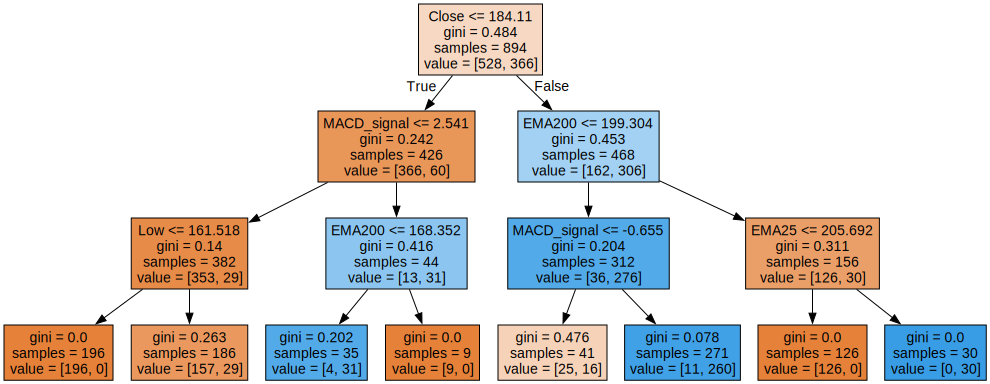

In [26]:
dot_data = tree.export_graphviz(
    clf, out_file=None, filled=True, feature_names=predictors_list)
graphviz.Source(dot_data)

In [27]:
def decision_tree_signal(row):
    if row['MACD_signal'] <= -0.415:
        if row['EMA25'] <= 205.692:
            if row['EMA200'] <= 198.888:
                if row['MACD_hist'] <= -1.137:
                    return 'Buy'
                else:
                    return 'Sell'
            else:
                return 'Sell'
        else:
            return 'Sell'
    else:
        if row['EMA25'] <= 181.608:
            return 'Sell'
        else:
            return 'Buy'


In [28]:
df['Signal'] = df.apply(decision_tree_signal, axis=1)

# แยกเป็นจุดซื้อ-ขาย
buy_signals = df[df['Signal'] == 'Buy']
sell_signals = df[df['Signal'] == 'Sell']


In [29]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist,Signal
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448,Sell
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633,Sell
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187,Sell
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236,Sell
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199,Buy
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165,Buy
1314,2025-06-09,291.000000,292.000000,288.000000,289.000000,1,290.687313,284.557831,269.123834,47.914500,0.610458,1.736357,-1.125899,Buy
1315,2025-06-10,288.000000,291.000000,287.000000,288.000000,1,290.480597,284.648415,269.311656,46.561414,0.312027,1.451491,-1.139464,Buy


In [30]:
# สมมุติว่า df['Signal'] มีค่าเป็น 'Buy', 'Sell', หรือ None/NaN
df['Target'] = df['Signal'].map({'Buy': 1, 'Sell': 0})


In [31]:
df.dropna(subset=['Target'], inplace=True)


In [33]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist,Signal
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448,Sell
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633,Sell
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187,Sell
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236,Sell
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199,Buy
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165,Buy
1314,2025-06-09,291.000000,292.000000,288.000000,289.000000,1,290.687313,284.557831,269.123834,47.914500,0.610458,1.736357,-1.125899,Buy
1315,2025-06-10,288.000000,291.000000,287.000000,288.000000,1,290.480597,284.648415,269.311656,46.561414,0.312027,1.451491,-1.139464,Buy


In [34]:
df['target_cls'] = df['Signal'].shift(-1)


🎯 1. จาก Signal เป็น target_cls (Classification)
แนวคิด:
ใช้สัญญาณในวันนี้ เพื่อให้โมเดลทำนาย “พรุ่งนี้ควรจะทำอะไร (ซื้อหรือขาย)”

python
Copy
Edit
df['target_cls'] = df['Signal'].shift(-1)
ความหมาย:
1 = พรุ่งนี้ควรซื้อ (ราคามีแนวโน้มขึ้น)

-1 = พรุ่งนี้ควรขาย (ราคามีแนวโน้มลง)

0 = ไม่ทำอะไร (Hold)

In [35]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist,Signal,target_cls
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448,Sell,Sell
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633,Sell,Sell
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187,Sell,Sell
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236,Sell,Sell
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514,Sell,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199,Buy,Buy
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165,Buy,Buy
1314,2025-06-09,291.000000,292.000000,288.000000,289.000000,1,290.687313,284.557831,269.123834,47.914500,0.610458,1.736357,-1.125899,Buy,Buy
1315,2025-06-10,288.000000,291.000000,287.000000,288.000000,1,290.480597,284.648415,269.311656,46.561414,0.312027,1.451491,-1.139464,Buy,Buy


In [36]:
df.dropna(subset=['target_cls'], inplace=True)


📊 2. จาก Signal เป็น target_rgs (Regression)
แนวคิด:
ใช้สัญญาณวันนี้ เพื่อให้โมเดลทำนาย “พรุ่งนี้ผลตอบแทนจะเป็นเท่าไหร่ (continuous return)”

python
Copy
Edit
df['target_rgs'] = df['Return'].shift(-1)
โดยไม่จำเป็นต้องใช้ Signal โดยตรงเป็น target แต่ใช้เพื่อสร้างสัญญาณ แล้วนำผลตอบแทนที่แท้จริงมาเป็นเป้าหมายให้โมเดลเรียนรู้

✨ หากคุณต้องการเปลี่ยนจาก Signal → target_cls โดยใช้การกระทำแทน:
Signal	ความหมาย	target_cls (แปลงเป็น Binary)
1	Buy	1
-1	Sell	0
0	Hold/No action	อาจเลือก 0 หรือ drop ทิ้ง

python
Copy
Edit
df['target_cls'] = df['Signal'].replace({1: 1, -1: 0, 0: np.nan})
df.dropna(subset=['target_cls'], inplace=True)
df['target_cls'] = df['target_cls'].astype(int)


In [38]:
df['Return'] = df['Close'].pct_change()


In [40]:
df['target_rgs'] = df['Return'].shift(-1)              # สำหรับ regression
df['target_cls'] = (df['Return'].shift(-1) > 0).astype(int)  # สำหรับ classification



In [41]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist,Signal,target_cls,Return,target_rgs
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448,Sell,1,NaN,0.005814
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633,Sell,1,0.005814,0.008671
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187,Sell,0,0.008671,-0.011461
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236,Sell,0,-0.011461,-0.008696
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514,Sell,0,-0.008696,-0.002924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,2025-06-04,285.000000,294.000000,283.000000,293.000000,1,290.721659,284.051968,268.468157,53.366154,1.083203,2.599923,-1.516720,Buy,0,0.024476,0.000000
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199,Buy,0,0.000000,-0.010239
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165,Buy,0,-0.010239,-0.003448
1314,2025-06-09,291.000000,292.000000,288.000000,289.000000,1,290.687313,284.557831,269.123834,47.914500,0.610458,1.736357,-1.125899,Buy,0,-0.003448,-0.003460


In [42]:
df.dropna(subset=['target_rgs', 'target_cls'], inplace=True)


In [48]:
df

,Date,Open,High,Low,Close,Target,EMA25,EMA75,EMA200,RSI,MACD,MACD_signal,MACD_hist,Signal,target_cls,Return,target_rgs
199,2020-10-27,143.406301,144.664251,142.567667,144.244934,0,146.415929,150.715527,158.562357,42.095232,-1.349116,-1.390564,0.041448,Sell,1,NaN,0.005814
200,2020-10-28,143.825592,145.083542,143.406275,145.083542,0,146.313438,150.567317,158.428239,45.155685,-1.256022,-1.363656,0.107633,Sell,1,0.005814,0.008671
201,2020-10-29,145.083557,146.341507,144.244924,146.341507,0,146.315597,150.456112,158.307973,49.470029,-1.068421,-1.304609,0.236187,Sell,0,0.008671,-0.011461
202,2020-10-30,146.760829,146.760829,143.825612,144.664246,0,146.188570,150.303694,158.172215,44.449319,-1.043064,-1.252300,0.209236,Sell,0,-0.011461,-0.008696
203,2020-11-02,145.502895,145.502895,143.406311,143.406311,0,145.974550,150.122184,158.025290,41.081769,-1.111658,-1.224171,0.112514,Sell,0,-0.008696,-0.002924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2025-05-30,287.000000,291.000000,284.000000,286.000000,1,290.531798,283.810129,268.221606,43.919726,1.032064,2.979103,-1.947039,Buy,1,-0.003484,0.024476
1311,2025-06-04,285.000000,294.000000,283.000000,293.000000,1,290.721659,284.051968,268.468157,53.366154,1.083203,2.599923,-1.516720,Buy,0,0.024476,0.000000
1312,2025-06-05,295.000000,295.000000,291.000000,293.000000,1,290.896916,284.287442,268.712255,53.366154,1.110924,2.302123,-1.191199,Buy,0,0.000000,-0.010239
1313,2025-06-06,293.000000,295.000000,289.000000,290.000000,1,290.827923,284.437773,268.924073,49.243306,0.880667,2.017832,-1.137165,Buy,0,-0.010239,-0.003448


In [49]:
y_cls = df.target_cls
y_cls.tail()



1310    1
1311    0
1312    0
1313    0
1314    0
Name: target_cls, dtype: int32

In [50]:
y_rgs = df.target_rgs
y_rgs.tail()

1310    0.024476
1311    0.000000
1312   -0.010239
1313   -0.003448
1314   -0.003460
Name: target_rgs, dtype: float64

In [51]:
from sklearn.model_selection import train_test_split
y=y_cls
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

print (X_cls_train.shape, y_cls_train.shape)
print (X_cls_test.shape, y_cls_test.shape)

(781, 11) (781,)
(335, 11) (335,)


# Splitting the data into training and testing data sets
The last step to finish with the preparation of the data sets is to split them into train and test data sets. This is necessary to fit the model with a set of data, usually 70% or 80% and the remainder, to test the goodness of the model. If we do not do so, we would run the risk of over-fitting the model. We want to test the model with unknown data, once the model has been fitted in order to evaluate the model accuracy.

We’re going to create the train data set with the 70% of the data from predictor and target variables data sets and the remainder 30% to test the model.

For classification decision trees, we’re going to use the traintestsplit function from sklearn modelselection library to split the dataset. Since the output is categorical, it is important that the training and test datasets are proportional traintest_split function has as input the predictor and target datasets and some input parameters:

test_size: the size of the test data set, in this case, 30% of the data for the tests and, therefore, 70% for the training.
random_state: Since the sampling is random, this parameter allows us to reproduce the same randomness in each execution.
stratify: To ensure that the training and test sample data are proportional, we set the parameter to yes. This means that, for example, if there are more days with positive than negative return, the training and test samples will keep the same proportion.

# Here we have:

Train predictor variables dataset: X_cls_train
Train target variables dataset: y_cls_train
Test predictor variables dataset: X_cls_test
Test target variables dataset: y_cls_test
For regression decision trees we simply split the data at the specified rate, since the output is continuous, we don’t worry about the proportionality of the output in training and test datasets.

In [52]:
train_length = int(len(df)*0.70)
X_rgs_train = X[:train_length]
X_rgs_test = X[train_length:]
y_rgs_train = y_rgs[:train_length]
y_rgs_test = y_rgs[train_length:]

print (X_rgs_train.shape, y_rgs_train.shape)
print (X_rgs_test.shape, y_rgs_test.shape)

(781, 11) (781,)
(335, 11) (335,)


In [53]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

# Now we are going to train the model with the training datasets, we fit the model and the algorithm would already be fully trained.

In [54]:
clf = clf.fit(X_cls_train, y_cls_train)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

# Now we need to make forecasts with the model on unknown data, for this we will use 30% of the data that we had left reserved for testing and, finally, evaluate the performance of the model. But first, let’s take a graphical look at the classification decision tree that the ML algorithm has automatically created for us.

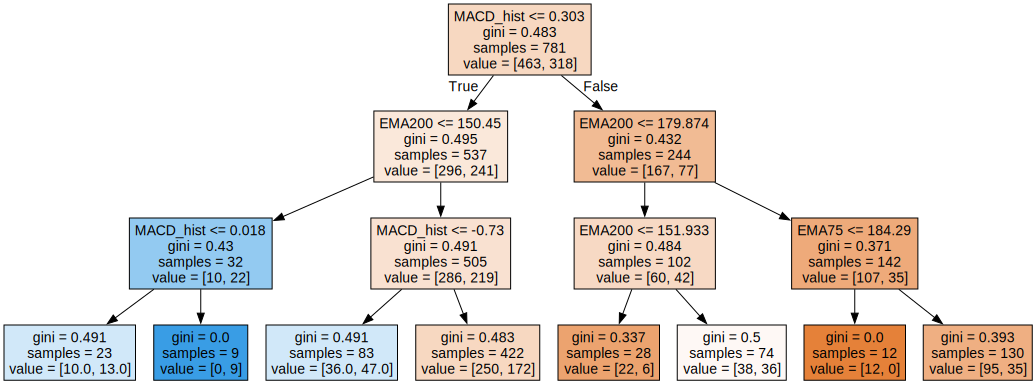

In [55]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)
graphviz.Source(dot_data)

# Make forecast
Now let’s make predictions with data sets reserved for testing, this is the part that will let us know if the algorithm is reliable with unknown data in training.

In [56]:
y_cls_pred = clf.predict(X_cls_test)


# Performance analysis
Finally, we can only evaluate the performance of the algorithm on unknown data by comparing it with the result obtained in the training process. To do this we will use the classification_report function of the sklearn.metrics library.

The report shows some parameters that will help us to evaluate the goodness of the algorithm:

Precision: Indicate the quality of our predictions.
Recall: Indicate the quality of our predictions.
F1-score: Shows the harmonic mean of precision and recall.
Support: Used as weights to compute the average values of precision, recall and F-1.

In [57]:
from sklearn.metrics import classification_report
report = classification_report(y_cls_test, y_cls_pred)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.80      0.68       199
           1       0.37      0.17      0.23       136

    accuracy                           0.54       335
   macro avg       0.47      0.48      0.45       335
weighted avg       0.50      0.54      0.49       335



# Decision Trees for Regression
Now let’s create the regression decision tree using the DecisionTreeRegressor function from the sklearn.tree library.

Although the DecisionTreeRegressor function has many parameters that I invite you to know and experiment with (help(DecisionTreeRegressor)), here we will see the basics to create the regression decision tree.

# criterion คือ ตัวชี้วัดความผิดพลาดของโมเดล เช่น MSE หรือ MAE ใช้เพื่อประเมินและปรับปรุงความแม่นยำของต้นไม้

# max_depth คือ ความลึกสูงสุดของต้นไม้ ถ้าไม่กำหนดจะลึกได้ไม่จำกัด

# min_samples_leaf คือ จำนวนข้อมูลขั้นต่ำที่ต้องมีในแต่ละใบไม้ ช่วยลดการซับซ้อนและป้องกันการ overfitting

In [58]:
# Regression tree model
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 200)

In [59]:
dtr.fit(X_rgs_train, y_rgs_train)

DecisionTreeRegressor(min_samples_leaf=200)

# ขั้นตอน
# แบ่งข้อมูลเป็น Train (70%) และ Test (30%)

# สร้างโมเดล Decision Tree Classifier

วาดแผนภูมิ Decision Tree แบบกราฟิก

ทำนายข้อมูล Test และประเมินผล (accuracy, classification report)



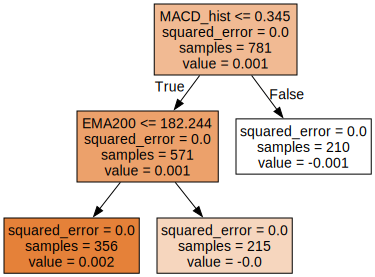

In [60]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr,
                  out_file=None,
                  filled=True,
                  feature_names=predictors_list)
graphviz.Source(dot_data)

# เส้นทางการตัดสินใจของต้นไม้ที่ใช้ EMA200 เป็นเกณฑ์ในการแบ่งข้อมูลแสดงว่า

หาก EMA200 ต่ำกว่าหรือเท่ากับ 182.244 คาดว่าจะได้ผลตอบแทนเฉลี่ยประมาณ +0.1%

# หาก EMA200 สูงกว่า 182.244 จะมี 2 กลุ่มย่อยคือ กลุ่มที่คาดว่าจะได้ผลตอบแทนเฉลี่ยประมาณ -0.1% และกลุ่มที่คาดว่าจะได้ผลตอบแทนประมาณ +0.2%

# the predictor variable used to split the data set.
the value of MSE.
the number of data points available at that node

# คำอธิบายต้นไม้ตัดสินใจ (Decision Tree) สำหรับการทำนายค่าผลตอบแทนหุ้น
ต้นไม้ตัดสินใจนี้ใช้ตัวชี้วัดทางเทคนิค เช่น MACD Histogram (MACD_hist) และค่าเฉลี่ยเคลื่อนที่ EMA200 (EMA200) เพื่อแบ่งข้อมูลออกเป็นกลุ่มย่อย ๆ ที่มีลักษณะคล้ายกัน และทำนายค่าผลตอบแทน (return) ของหุ้นในวันถัดไป

โครงสร้างของต้นไม้
Node แรก:
เช็คเงื่อนไขว่า MACD_hist <= 0.345

หาก ใช่ (True) ข้อมูลจะถูกแบ่งไปที่ Node ถัดไปทางซ้าย

หาก ไม่ใช่ (False) ข้อมูลจะถูกแบ่งไปทางขวา

Node ซ้าย:
เช็คเงื่อนไขว่า EMA200 <= 182.244

ถ้าใช่ ข้อมูลกลุ่มนี้มีค่าผลตอบแทนเฉลี่ยประมาณ 0.001

ถ้าไม่ใช่ ข้อมูลกลุ่มนี้มีค่าผลตอบแทนเฉลี่ยประมาณ -0.001

Node ขวา:
ข้อมูลกลุ่มนี้มีค่าผลตอบแทนเฉลี่ยประมาณ 0.002

ความหมายของแต่ละค่าใน Node
samples: จำนวนตัวอย่างข้อมูลที่อยู่ใน node นั้น ๆ

value: ค่าผลตอบแทนเฉลี่ยของตัวอย่างใน node นั้น (คือค่าที่ต้นไม้ทำนายได้)

squared_error: ค่าความคลาดเคลื่อนรวมของตัวอย่างใน node นั้น (ถ้าค่านี้ต่ำ หมายถึงโมเดลพยากรณ์ได้แม่นยำใน node นั้น)